## load package

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install torchinfo
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-bo7jj_6j
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-bo7jj_6j
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e7cbea0bbd546167b9d1757b2cfeca3fbe26a33e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 53.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.0 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.2-py

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torchinfo
import segmentation_models_pytorch as smp
from transformers import get_linear_schedule_with_warmup

In [ ]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import jaccard_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/0197Group/Dataset/img.npy.zip'
!unzip '/content/drive/MyDrive/0197Group/Dataset/label.npy.zip'
!unzip '/content/drive/MyDrive/0197Group/Dataset/size.npy.zip'



Archive:  /content/drive/MyDrive/0197Group/Dataset/img.npy.zip
  inflating: img.npy                 
Archive:  /content/drive/MyDrive/0197Group/Dataset/label.npy.zip
  inflating: label.npy               
Archive:  /content/drive/MyDrive/0197Group/Dataset/size.npy.zip
  inflating: size.npy                


In [ ]:
test_img = np.load('img.npy')
print(test_img.shape)

test_label = np.load('label.npy')
print(test_label.shape)

test_size = np.load('size.npy')
print(test_size.shape)

(7390, 256, 256, 3)
(7390, 256, 256)
(7390, 2)


In [ ]:
test_label[test_label==1] = 0
test_label[test_label==2] = 1
test_label[test_label==3] = 2

np.unique(test_label)

array([0, 1, 2], dtype=uint8)

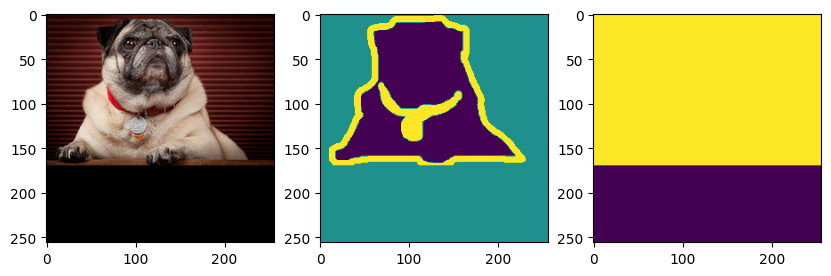

In [ ]:
test_mask = np.zeros_like(test_img[:,:,:,0])
for i in range(len(test_img)):
  test_mask[i,0:test_size[i,0],0:test_size[i,1]] = 1


_, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
ax[0].imshow(test_img[1])
ax[1].imshow(test_label[1].astype(int))
ax[2].imshow(test_mask[1]*255.)

In [ ]:
class Finetune_set(Dataset):
  
  def __init__(self, img, label, mask, size):
    super().__init__()
    self.img = torch.Tensor(img).float().permute((0,3,1,2))/255.
    self.label = torch.Tensor(label).float() 
    self.mask = torch.Tensor(mask).float()
    self.size = torch.Tensor(size).float()

  def __len__(self):
    return len(self.img)

  def __getitem__(self,idx):
    return self.img[idx], self.label[idx], self.mask[idx], self.size[idx]

In [ ]:

np.random.seed(42)

ids = list(range(test_img.shape[0]))
np.random.shuffle(ids)

# 40% labelled data, 60% unlabelled data
labelled_ids = ids[:int(0.4*test_img.shape[0])]
unlabelled_ids = ids[int(0.4*test_img.shape[0]):]

# 80% training, 5% validation, 15% test
train_ids = labelled_ids[:int(0.8*len(labelled_ids))]
valid_ids = labelled_ids[int(0.8*len(labelled_ids)):int(0.85*len(labelled_ids))]
test_ids = labelled_ids[int(0.85*len(labelled_ids)):]

# validation and test sets stay the same
valid_set = Finetune_set(test_img[valid_ids], test_label[valid_ids], test_mask[valid_ids], test_size[valid_ids])
test_set = Finetune_set(test_img[test_ids], test_label[test_ids], test_mask[test_ids], test_size[test_ids])
print(len(valid_set), len(test_set))

# training set for baseline and semi-supervised
base_train_set = Finetune_set(test_img[train_ids], test_label[train_ids], test_mask[train_ids], test_size[train_ids])
print(len(base_train_set))

# training set for upper bound
upper_train_set = Finetune_set(test_img[train_ids+unlabelled_ids], test_label[train_ids+unlabelled_ids], test_mask[train_ids+unlabelled_ids], test_size[train_ids+unlabelled_ids])
print(len(upper_train_set))

148 444
2364
6798


## functions

In [ ]:
def inference(image, label, mask, size, model, device):

    concated = torch.concat([image, mask.unsqueeze(0)], dim=0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(concated.unsqueeze(0))

    del concated
    
    trimap = torch.argmax(output.squeeze().detach().cpu().permute(1,2,0), dim=2)
    if size[1] == 256:
      trimap[int(size[0]):, :] = 1
    else:
      trimap[:, int(size[1]):] = 1
  
    _, ax = plt.subplots(nrows=1, ncols=3, figsize=(6,3))
    ax[0].imshow(image.permute(1,2,0).cpu())
    ax[1].imshow(label.cpu())
    ax[2].imshow(trimap)
    plt.show()

def calculate_batch_metrics(y_true_batch, y_pred_batch):
    '''
    input: label_batch, output_batch
    output: iou, precision, recall, f1_score
    '''
    batch_size = y_true_batch.shape[0]
    batch_metrics = []

    for i in range(batch_size):
        y_true = y_true_batch[i].flatten()
        y_pred = y_pred_batch[i].flatten()

        iou = jaccard_score(y_true, y_pred, average="weighted")
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

        sample_metrics = [iou, precision, recall, f1_score]
        batch_metrics.append(sample_metrics)

    return np.array(batch_metrics)

# Open question: is there margin effect for increasing labelled data?

We use different size of trainig set, to observe the effect

totally 6798 train data available, 0.7 of them is used
model loaded
Early stopped at step:  1700


100%|██████████| 7/7 [00:17<00:00,  2.43s/it]



mean iou: 0.8477, precision: 0.9150, recall: 0.9082, f1-score: 0.9073


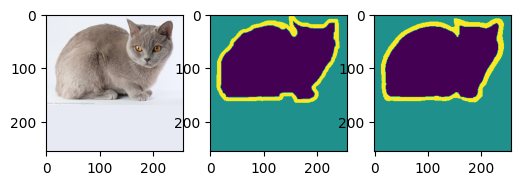

totally 6798 train data available, 0.9 of them is used
model loaded
Early stopped at step:  1800


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]



mean iou: 0.8526, precision: 0.9182, recall: 0.9114, f1-score: 0.9105


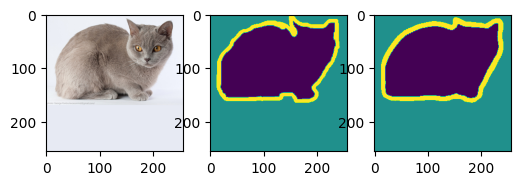

In [ ]:
portion_li = [0.7, 0.9]
for portion in portion_li:
  total_train_ids = np.concatenate([unlabelled_ids,train_ids])
  length = len(total_train_ids)

  ex_train_ids = total_train_ids[:int(length*portion)]
  ex_train_set = base_train_set = Finetune_set(test_img[ex_train_ids], test_label[ex_train_ids], test_mask[ex_train_ids], test_size[ex_train_ids])
  print(f'totally {length} train data available, {portion} of them is used')

  batch_size = 64

  # validation and test sets stay the same
  valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size, num_workers=2)
  test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, num_workers=2)

  # need to choice which trainset to use
  train_loader = DataLoader(ex_train_set, shuffle=True, batch_size=batch_size, num_workers=2)

  upper_train_loader = DataLoader(upper_train_set, shuffle=True, batch_size=batch_size, num_workers=2)

  finetune= smp.Unet(
      encoder_name="resnet34",         # use ResNet34 as backbone
      encoder_weights=None,            # use randomly initialized weights
      encoder_depth=5,                 # number of stages used in encoder (default=5, each reduces the feature spatial dimensions by 1/2)
      decoder_use_batchnorm=True,      # if True, BatchNorm2d layer between Conv2D and Activation layers is used
      decoder_attention_type=None,     # attention module used in decoder (default=None)
      in_channels=4,                   # number of input channels, 1 additional attention mask (default=3, expects RGB images)
      activation=None,                 # activation function to apply after the final convolution layer (default=None)
      classes=3,                       # output 3 channels for trimaps
      aux_params=None,                 # parameters of the auxiliary output (defualt=None)
  )

  finetune.to(device)

  print("model loaded")

  lr = 3e-4
  warm_up = 500
  save_step = 50
  training_step = 5000

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(finetune.parameters(), lr=lr)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warm_up ,num_training_steps=training_step)

  model_name = 'jieming_base_portion='+str(portion)

  loss_list = []
  valid_loss_list = []
  step = 0

  stop = 0
  best_loss = float('inf')
  continue_training = True

  while True:

      for X in train_loader:

          img, label, mask = X[0].to(device), X[1].long().to(device), X[2].to(device)
          concated = torch.concat([img, mask.unsqueeze(1)], dim=1) 

          finetune.train()
          output = finetune(concated)
          loss = criterion(output*(mask.unsqueeze(1)), (label*mask).long())
          loss_list.append(loss.item())

          del img
          del label
          del mask

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          scheduler.step()
          step += 1

          if step % save_step == 0:
              
              finetune.eval()
              total_loss = 0.0
              for X in valid_loader:
                  img, label, mask = X[0].to(device), X[1].long().to(device), X[2].to(device)
                  concated = torch.concat([img, mask.unsqueeze(1)], dim=1) 
                  with torch.no_grad():
                      output = finetune(concated)
                  loss = criterion(output*(mask.unsqueeze(1)), (label*mask).long())
                  total_loss += loss.item() * img.shape[0]

                  del img
                  del label
                  del mask

              valid_loss = total_loss/len(valid_loader.dataset)
              valid_loss_list.append(valid_loss)

              if len(valid_loss_list) > 3:
                if valid_loss >= best_loss:
                  stop += 1
                else:
                  best_loss = valid_loss
                  stop = 0
                  model_state_dict = {'encoder': finetune.encoder.state_dict(),
                                  'decoder': finetune.decoder.state_dict(),
                                  'mask': finetune.segmentation_head.state_dict(),
                                  'optimizer': optimizer.state_dict(),
                                  'scheduler': scheduler.state_dict()}
                  torch.save(model_state_dict, f'/content/drive/MyDrive/0197Group/Model/{model_name}.pth')
              
                  

          if stop >= 8:
            break

      if stop >= 8:
          # model_state_dict = {'encoder': finetune.encoder.state_dict(),
          #                 'decoder': finetune.decoder.state_dict(),
          #                 'mask': finetune.segmentation_head.state_dict(),
          #                 'optimizer': optimizer.state_dict(),
          #                 'scheduler': scheduler.state_dict()}
          # torch.save(model_state_dict, f'/content/drive/MyDrive/0197Group/Model/{model_name}.pth')
          # print(f'Model checkpoint saved at step {step}')
          print('Early stopped at step: ', step)
          break
              
      if step == training_step:
          break

  np.save(f'/content/drive/MyDrive/0197Group/Loss/{model_name}_train_loss.npy', np.array(loss_list))
  np.save(f'/content/drive/MyDrive/0197Group/Loss/{model_name}_valid_loss.npy', np.array(valid_loss_list))

  ckpt_finetune = torch.load(f'/content/drive/MyDrive/0197Group/Model/{model_name}.pth')
  finetune.encoder.load_state_dict(ckpt_finetune['encoder'])
  finetune.decoder.load_state_dict(ckpt_finetune['decoder'])
  finetune.segmentation_head.load_state_dict(ckpt_finetune['mask'])

  del ckpt_finetune

  metrics = [[0,0,0,0]]
  for X in tqdm(test_loader):
    img, label_batch, mask, size_batch = X[0].to(device), X[1].long(), X[2].to(device), X[3]
    concated = torch.concat([img, mask.unsqueeze(1)], dim=1)
    output = finetune(concated)
    trimap_batch = torch.argmax(output.squeeze().detach().cpu().permute(0, 2, 3, 1), dim=3)
    for i in range(len(trimap_batch)):
      # trimap = trimap_batch[i]
      size = size_batch[i]
      if size[1] == 256:
        trimap_batch[i][int(size[0]):, :] = 1
      else:
        trimap_batch[i][:, int(size[1]):] = 1

    del img
    del mask

    batch_metrics = calculate_batch_metrics(label_batch, trimap_batch)
    metrics = np.concatenate((metrics, batch_metrics), axis = 0)
  mask_metrics = np.mean(metrics[1:], axis = 0)
  print("\n")
  print(f"mean iou: {mask_metrics[0]:.4f}, precision: {mask_metrics[1]:.4f}, recall: {mask_metrics[2]:.4f}, f1-score: {mask_metrics[3]:.4f}")
  img, label, mask, size = next(iter(test_loader))
  inference(img[i], label[i], mask[i], size[i], finetune, device)

  del finetune

portion0.1: mean iou: 0.6753, precision: 0.7987, recall: 0.7873, f1-score: 0.7761

portion0.3: mean iou: 0.7779, precision: 0.8758, recall: 0.8582, f1-score: 0.8587

portion0.5: mean iou: 0.8095, precision: 0.8936, recall: 0.8834, f1-score: 0.8799

portion0.7: mean iou: 0.8477, precision: 0.9150, recall: 0.9082, f1-score: 0.9073

portion0.9: mean iou: 0.8526, precision: 0.9182, recall: 0.9114, f1-score: 0.9105